In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset into a Pandas DataFrame
raw_df = pd.read_csv('WFPS_Call_Logs.csv')
data = raw_df.copy()


The dataset contains information about emergency calls that the Winnipeg Fire Paramedic Service (WFPS) responded to between 2015 and the present. The dataset includes the following columns:
<ul>
<li>Incident Number: A unique identifier for each incident.
<li>Incident Type: Indicates whether it was a "Medical Response" or another type of incident.
<li>Call Time: The time when the call was made.
<li>Closed Time: The time when the incident was resolved or closed.
<li>Motor Vehicle Incident: Indicates whether the incident involved a motor vehicle collision (Yes/No).
<li>Units: Lists the units that responded to the incident.
<li>Neighbourhood: Specifies the neighborhood where the incident occurred.
<li>Ward: Indicates the electoral ward in which the incident took place.
</ul>

In [3]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889721 entries, 0 to 889720
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Incident Number         889721 non-null  int64 
 1   Incident Type           889721 non-null  object
 2   Call Time               889721 non-null  object
 3   Closed Time             889660 non-null  object
 4   Motor Vehicle Incident  889721 non-null  object
 5   Units                   813756 non-null  object
 6   Neighbourhood           889721 non-null  object
 7   Ward                    889721 non-null  object
dtypes: int64(1), object(7)
memory usage: 54.3+ MB


**Quick check to see if we have any missing values**
<hr>

<Axes: >

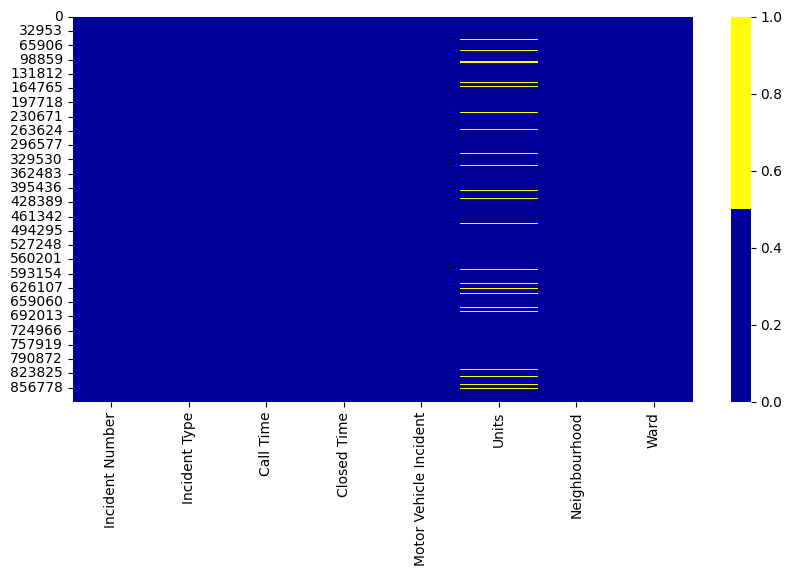

In [4]:
# quick check to see if we have any missing values
# Areas with missing values are highlited yellow.
plt.figure(figsize=(10,5))
cols = data.columns
colors = ['#000099', '#ffff00']
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colors))

## Data Quality Report

In [5]:
# Convert 'Call Time' and 'Closed Time' columns to datetime objects
data['Call Time'] = pd.to_datetime(data['Call Time'])
data['Closed Time'] = pd.to_datetime(data['Closed Time'])

In [6]:
# Function to generate data quality report for continuous features
def generate_continuous_report(auto, features):
    report = pd.DataFrame(columns=['Feature', 'Count', 'Missing %', 'Card.', 'Min', '1st Qrt.', 'Mean', 'Median', '3rd Qrt.', 'Max', 'Std Dev'])
    report_data = []
    
    for feature in features:
        count = auto[feature].count()
        missing_values = auto[feature].isnull().sum()
        missing_values_percentage = (missing_values / count) * 100
        minimum = auto[feature].min()
        cardinality = auto[feature].nunique()
        q1 = auto[feature].quantile(0.25)
        mean = auto[feature].mean()
        median = auto[feature].median()
        q3 = auto[feature].quantile(0.75)
        maximum = auto[feature].max()
        std_dev = auto[feature].std()
        
        report_data.append([feature, count, missing_values_percentage, cardinality, minimum, q1, mean, median, q3, maximum, std_dev])

    report = pd.concat([report, pd.DataFrame(report_data, columns=report.columns)], ignore_index=True)
    return report

# Function to generate data quality report for categorical features
def generate_categorical_report(auto, features):
    report = pd.DataFrame(columns=['Feature', 'Count', 'Missing %', 'Card.', 'Mode', 'Mode Freq.', 'Mode %',
                                   '2nd Mode', '2nd Mode Freq.', '2nd Mode %'])
    report_data = []
    
    for feature in features:
        count = auto[feature].count()
        missing_values = auto[feature].isnull().sum()
        missing_values_percentage = (missing_values / count) * 100 if count != 0 else 0
        cardinality = auto[feature].nunique()
        mode = auto[feature].mode().values[0]
        mode_frequency = auto[feature].value_counts().max()
        mode_percentage = (mode_frequency / count) * 100

        second_mode = ""
        second_mode_frequency = 0
        second_mode_percentage = 0

        if cardinality > 1:
            second_mode = auto[feature].value_counts().index[1]
            second_mode_frequency = auto[feature].value_counts().iloc[1]
            second_mode_percentage = (second_mode_frequency / count) * 100

        report_data.append([feature, count, missing_values_percentage, cardinality, mode, mode_frequency, mode_percentage,
                            second_mode, second_mode_frequency, second_mode_percentage])

    report = pd.concat([report, pd.DataFrame(report_data, columns=report.columns)], ignore_index=True)
    return report

In [7]:
# input the function into continuous and categorical features
# Separate categorical variables
categorical_features = data.select_dtypes(include=['object'])

# Generate the data quality report for categorical features
categorical_report = round(generate_categorical_report(data, categorical_features), 2)

# Separate continuous variables
continuous_features = data.select_dtypes(include=['int', 'float'])

# Generate the data quality report for continuous features
continuous_report = round(generate_continuous_report(data, continuous_features), 2)

----
#### Data Quality Report for Continuous Features
----

In [8]:
# Print the reports
continuous_report = pd.DataFrame(continuous_report).set_index('Feature')
continuous_report

,Count,Missing %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt.,Max,Std Dev
Feature,,,,,,,,,,
Incident Number,889721,0.0,889721,2014124756,2.017129e+09,2.021220e+09,2.020007e+09,2.022013e+09,20225000142,1.747859e+08


**Table Interpretation**
<hr>

    This analysis pertains to the "Incident Number" feature in the dataset. It reveals that there are 889,721 unique incident numbers, indicating each incident is uniquely identified. There are no missing values (0.0%), ensuring data completeness. The incident numbers vary from a minimum of 2014124756 to a maximum of 20225000142, demonstrating a wide range of values. 
    
    The mean incident number is around 2.021220e+09, with a standard deviation of approximately 1.747859e+08, indicating moderate variability. Quartile values provide insights into the distribution. Overall, this analysis provides a comprehensive understanding of the characteristics and range of incident numbers in the dataset.

----
#### Data Quality Report for Categorical Features
----

In [9]:
categorical_report = pd.DataFrame(categorical_report).set_index('Feature')
categorical_report

,Count,Missing %,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
Feature,,,,,,,,,
Incident Type,889721,0.00,12,Medical Emergency,549014,61.71,Medical Response,167492,18.83
Motor Vehicle Incident,889721,0.00,2,NO,872563,98.07,YES,17158,1.93
Units,813756,9.34,58348,SQ101,15588,1.92,SQ102,15527,1.91
Neighbourhood,889721,0.00,242,South Portage,27849,3.13,William Whyte,25264,2.84
Ward,889721,0.00,16,Point Douglas,112146,12.60,Mynarski,107566,12.09


**Table Interpretation**
<hr>

This table presents a summary of key statistics for several features in the dataset, offering insights into data distribution and characteristics. It includes:
1. **Incident Type:** With 889,721 records, "Medical Emergency" is the most common incident type (61.71%), followed by "Medical Response" (18.83%).
2. **Closed Time:** Most closed times are on "09/08/2016 03:50:53 PM," again with variability.
3. **Motor Vehicle Incident:** "NO" dominates (98.07%) compared to "YES" (1.93%).
4. **Units:** The data shows various units involved, with "SQ101" and "SQ102" being among the most frequent.
5. **Neighbourhood:** "South Portage" and "William Whyte" are the top neighborhoods, but there are 242 unique neighborhoods.
6. **Ward:** "Point Douglas" and "Mynarski" are the primary wards, each contributing over 10% of the data.

This analysis aids in understanding data distribution, mode values, and missing percentages, valuable for data preprocessing and analysis.

## Feature Engineering

In [10]:
# Calculate response times as the difference between 'Closed Time' and 'Call Time'
data['Response Time'] = data['Closed Time'] - data['Call Time']

# Calculate response times in minutes
data['Response Time (Minutes)'] = (data['Closed Time'] - data['Call Time']).dt.total_seconds() / 60

# Day of the Week Analysis
data['Day of Week'] = data['Call Time'].dt.day_name()

# Time of Day Analysis
data['Hour of Day'] = data['Call Time'].dt.hour

# Seasonality Analysis
data['Month'] = data['Call Time'].dt.month_name()


**Copy of the Data Set**
<hr>

In [11]:
# make a copy of the data frame
df = data.copy()

# drop the 'Units' column and all null values for easy analysis
df.dropna(axis=0, inplace=True)


In [12]:
# visualization style
# Set the style of the plot
sns.set(style="darkgrid")
sns.set_palette("coolwarm")

## Data Exploratory Analysis

---
#### Incident Types Analysis
---
    We will start by examining the distribution of incident types to understand the most common types of incidents that the Winnipeg Fire Paramedic Service responds to.

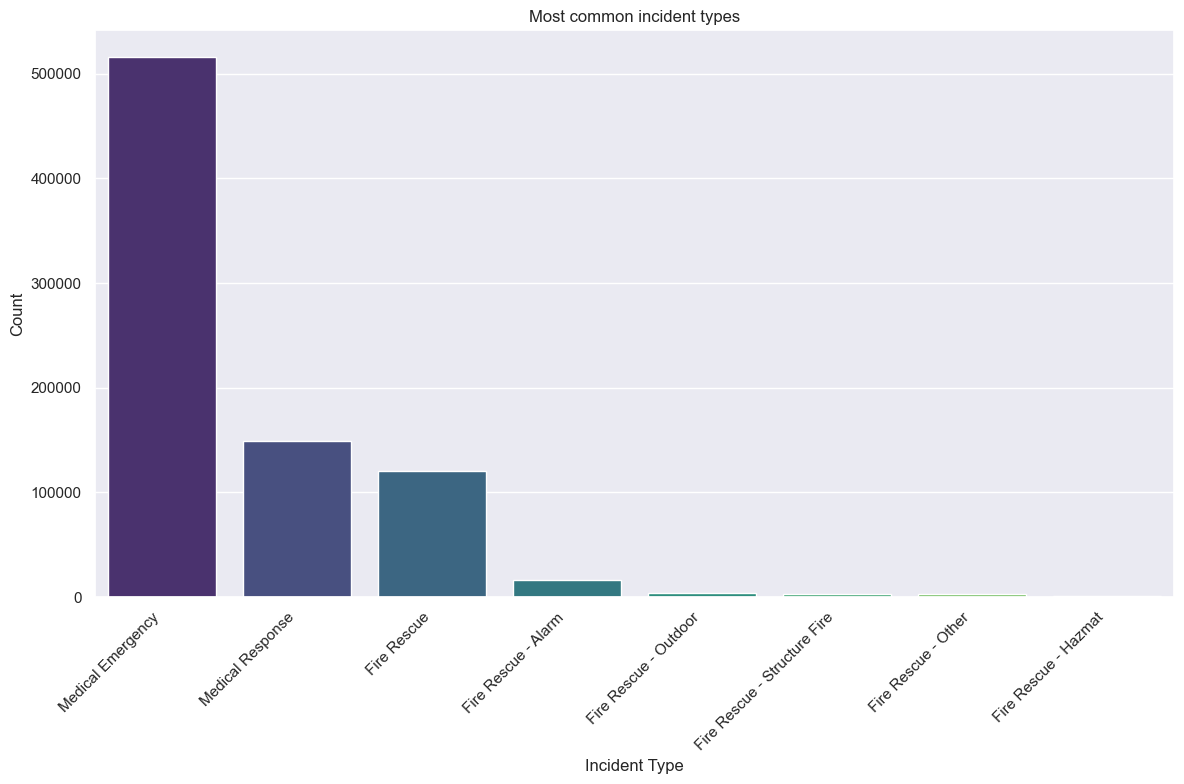

In [13]:
# Analyze the distribution of incident types
incident_type_counts = df['Incident Type'].value_counts()

# Create a DataFrame from the series
incident_type_df = pd.DataFrame({'Incident Type': incident_type_counts.index, 'Count': incident_type_counts.values})#.set_index('Incident Type')

top_5_incident_types = incident_type_counts.head(8)

# Create a bar plot for the top 5 incident types using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=top_5_incident_types.index, y=top_5_incident_types.values, palette="viridis")
plt.xlabel('Incident Type')
plt.ylabel('Count')
plt.title('Most common incident types')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


**Interpretation**
<hr>

    The "Incident Types Analysis" provides insight into the distribution of incident types that the Winnipeg Fire Paramedic Service encounters. It indicates that "Medical Emergency" is the most common incident type, with a significant count of 515,600 incidents. This highlights the service's substantial involvement in responding to medical crises and urgent health situations. "Medical Response" is the second most frequent type, indicating a range of medical situations that may not be emergencies but still require attention.

    Additionally, "Fire Rescue" incidents, including various subcategories like fire alarms, outdoor fires, and structure fires, collectively make up a significant portion of the service's responses, with a total count of 120,315 incidents. These findings underscore the multifaceted nature of the service's responsibilities, encompassing both medical and fire-related incidents.

    The analysis offers valuable insights into the diverse set of incidents handled by the service, guiding resource allocation, training, and preparedness efforts to effectively respond to the most common incident types in the community.

---
### Motor Vehicle Incidents Analysis
---
    Analyze the incidents involving motor vehicles to determine if there are any patterns or trends in terms of location (neighborhood or ward) or response times.

---
**Comparative Analysis**

In [14]:
# Filter the dataset for motor vehicle incidents
motor_vehicle_incidents = df[df['Motor Vehicle Incident'] == 'YES']

# Perform response time analysis specifically for motor vehicle incidents.
motor_vehicle_incidents['Response Time'] = motor_vehicle_incidents['Closed Time'] - motor_vehicle_incidents['Call Time']

# Check the Average, median, 25th and 75th percentile response time 
mean_response_time_motor_vehicle = motor_vehicle_incidents['Response Time'].mean()
median_response_time_motor_vehicle = motor_vehicle_incidents['Response Time'].median()
percentile_25th_motor_vehicle = motor_vehicle_incidents['Response Time'].quantile(0.25)
percentile_75th_motor_vehicle = motor_vehicle_incidents['Response Time'].quantile(0.75)

In [15]:
# # Filter the dataset for other types of incidents (non-motor vehicle incidents)
non_motor_vehicle_incidents = df[df['Motor Vehicle Incident'] == 'NO']

mean_response_time_other = non_motor_vehicle_incidents['Response Time'].mean()
median_response_time_other = non_motor_vehicle_incidents['Response Time'].median()
percentile_25th_other = non_motor_vehicle_incidents['Response Time'].quantile(0.25)
percentile_75th_other = non_motor_vehicle_incidents['Response Time'].quantile(0.75)

In [16]:
#Calculate the frequency of motor vehicle incidents to understand how often they occur.
motor_vehicle_incident_count = motor_vehicle_incidents.shape[0]
non_motor_vehicle_incident_count = non_motor_vehicle_incidents.shape[0]

# Create a DataFrame for comparative analysis
comparison_data = pd.DataFrame({
    'Incident Type': ['Motor Vehicle', 'Other'],
    'Mean Response Time (hours)': [mean_response_time_motor_vehicle, mean_response_time_other],
    'Median Response Time (hours)': [median_response_time_motor_vehicle, median_response_time_other],
    '25th Percentile Response Time (hours)': [percentile_25th_motor_vehicle, percentile_25th_other],
    '75th Percentile Response Time (hours)': [percentile_75th_motor_vehicle, percentile_75th_other],
    'Incident Count': [motor_vehicle_incident_count, non_motor_vehicle_incident_count]
})

# Display the comparative analysis table
comparison_data


,Incident Type,Mean Response Time (hours),Median Response Time (hours),25th Percentile Response Time (hours),75th Percentile Response Time (hours),Incident Count
0,Motor Vehicle,0 days 01:03:08.348809345,0 days 00:47:07,0 days 00:25:29,0 days 01:34:43.500000,13354
1,Other,0 days 01:28:54.955792117,0 days 01:21:08,0 days 00:26:00,0 days 01:57:58,800355


**Interpretation**
<hr>

    The analysis examines response times for two distinct categories of incidents: "Motor Vehicle" and "Other." For "Motor Vehicle" incidents, the data reveals an average response time of approximately 1 hour, 3 minutes, and 8 seconds, with a median response time of about 47 minutes and 7 seconds. This suggests relatively efficient and timely responses to motor vehicle-related emergencies, essential for mitigating potential hazards on the road.

    Conversely, "Other" incidents exhibit longer response times, with an average of around 1 hour, 28 minutes, and 55 seconds, and a median response time of approximately 1 hour, 21 minutes, and 8 seconds. This category encompasses a diverse range of incident types, and the extended response times may reflect the complexity or variability in these situations.

    The analysis underscores the importance of tailored response strategies for different incident categories, with a focus on optimizing response times for "Other" incidents to enhance overall emergency service effectiveness and public safety.

---
**Neighborhoods with the most motor vehicle incidents.**

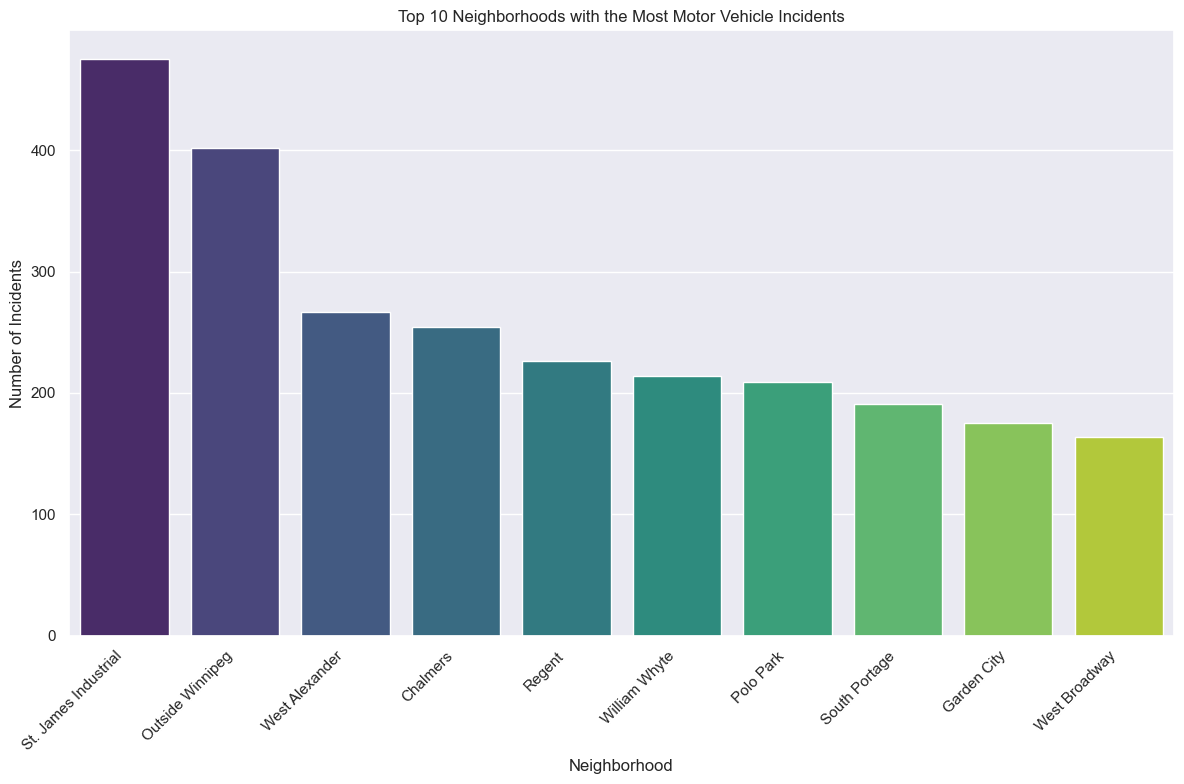

In [17]:
# Get the top 10 neighborhoods with the most motor vehicle incidents
top_10_neighborhoods = motor_vehicle_incidents['Neighbourhood'].value_counts().head(10)

# Create a bar plot of the top 10 neighborhoods
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_neighborhoods.index, y=top_10_neighborhoods.values, palette="viridis")
plt.title('Top 10 Neighborhoods with the Most Motor Vehicle Incidents')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha="right")  # Adjust rotation and alignment for x-axis labels
plt.tight_layout()
plt.show()

**Interpretation**
<hr>

    The analysis of motor vehicle incidents by neighborhoods in Winnipeg provides a comprehensive view of incident distribution. St. James Industrial records the highest incidence at 475, indicating a significant prevalence of incidents. "Outside Winnipeg" with 402 incidents extends the scope beyond city limits. 

    West Alexander follows closely with 267 incidents, highlighting traffic challenges. Several neighborhoods, including Chalmers, Regent, William Whyte, and Polo Park, report substantial incidents, underscoring the need for localized safety measures. South Portage, Garden City, and West Broadway also face notable incident numbers, requiring attention to enhance road safety. 

    This analysis aids authorities in resource allocation and targeted traffic management strategies tailored to each neighborhood's specific needs.

----
**Ward with the most motor vehicle incidents**

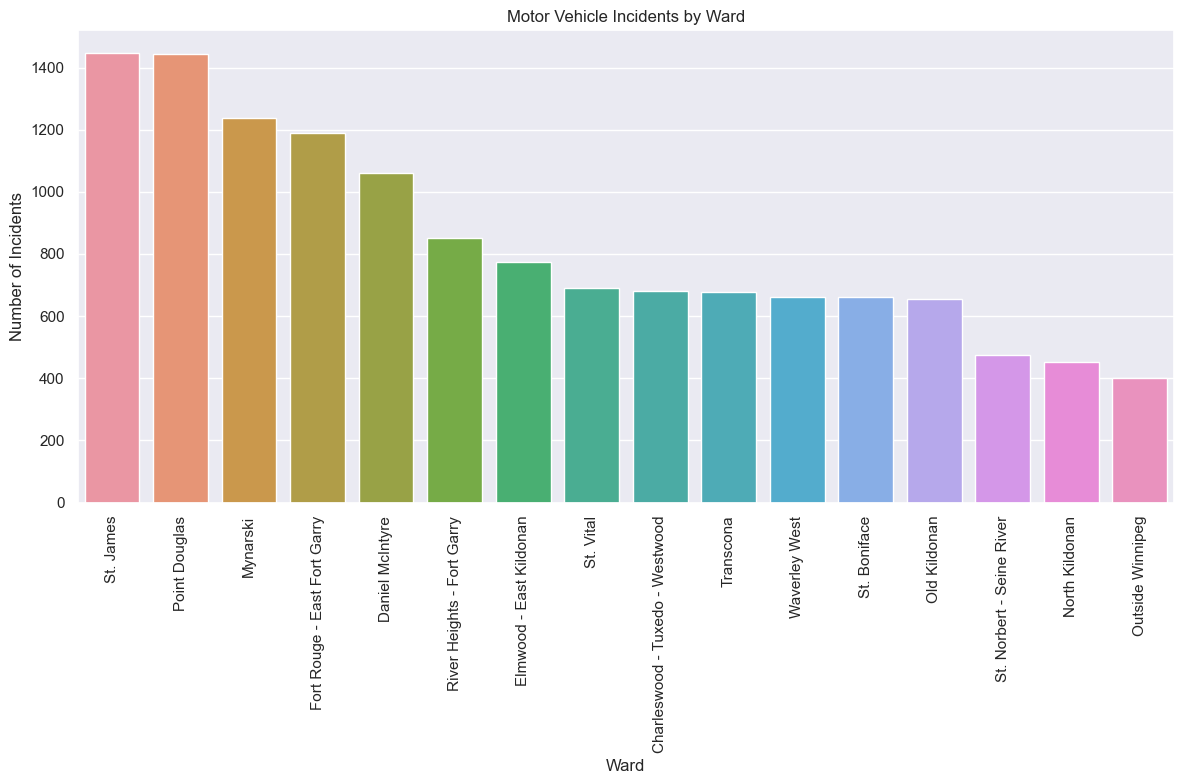

In [18]:
# Distribution by Ward
motor_vehicle_ward_counts = motor_vehicle_incidents['Ward'].value_counts()

# Visualization 1: Motor Vehicle Incidents by Ward
plt.figure(figsize=(12, 8))
sns.countplot(data=motor_vehicle_incidents, x='Ward', order=motor_vehicle_incidents['Ward'].value_counts().index)
plt.title('Motor Vehicle Incidents by Ward')
plt.xlabel('Ward')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Interpretation**
<hr>

    The analysis of motor vehicle incidents by ward in Winnipeg reveals varying levels of incident counts across different administrative areas. St. James leads with the highest count at 1,447 incidents, suggesting a significant prevalence of motor vehicle-related issues. Point Douglas follows closely with 1,442 incidents, indicating substantial incidents in this ward. Mynarski, with 1,237 incidents, also shows notable numbers, emphasizing the need for attention to road safety.

    Fort Rouge - East Fort Garry reports 1,189 incidents, indicating its significance in incident distribution. Daniel McIntyre, with 1,060 incidents, falls slightly behind. River Heights - Fort Garry, Elmwood - East Kildonan, St. Vital, and Charleswood - Tuxedo - Westwood all exhibit varying incident levels. Transcona, Waverley West, St. Boniface, Old Kildonan, St. Norbert - Seine River, and North Kildonan report lower incident counts. "Outside Winnipeg" with 402 incidents includes areas just outside city limits.

    This data aids authorities in prioritizing safety measures and resource allocation for improved road safety in each ward.

---
**The most Units involved in responding to Motor Vehicle Incidents.**

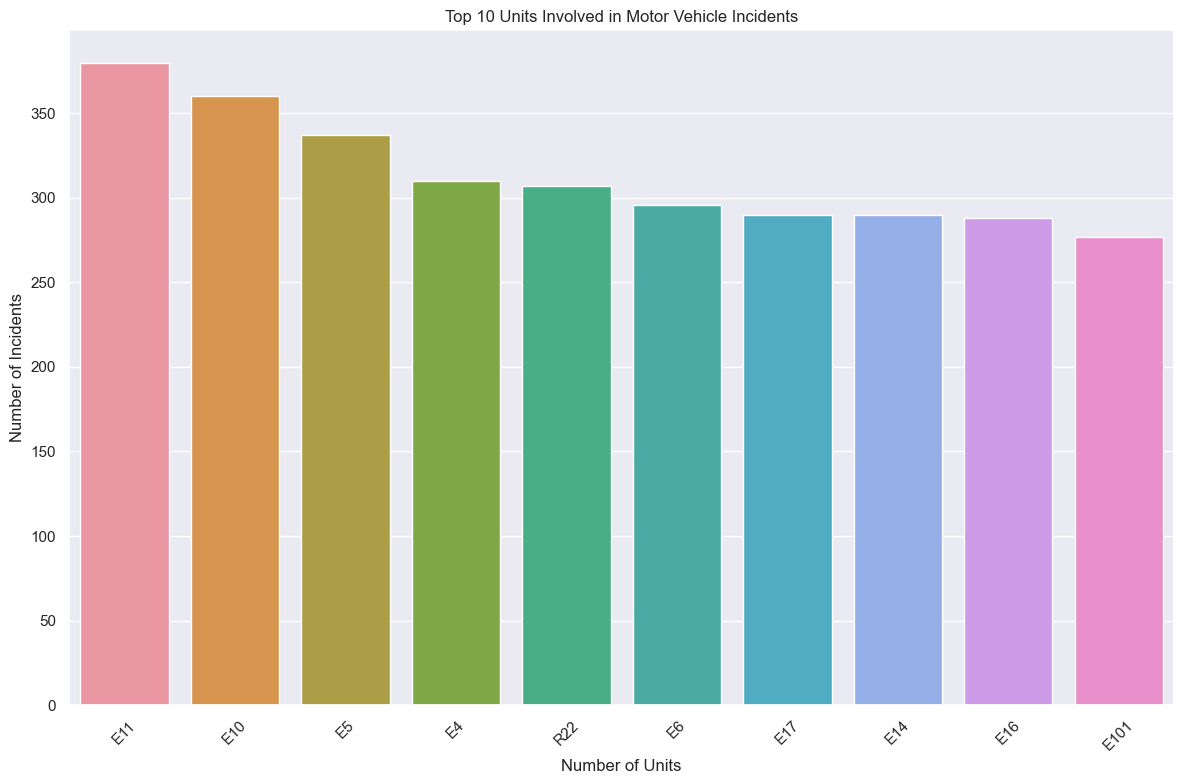

In [19]:
# Units Involved in Motor Vehicle Incidents
unit_counts_motor_vehicle = motor_vehicle_incidents['Units'].value_counts()

# Select the top 10 units
top_10_units = unit_counts_motor_vehicle.head(10)

# Create a bar plot for the top 10 units involved in motor vehicle incidents
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_units.index, y=top_10_units.values)
plt.title('Top 10 Units Involved in Motor Vehicle Incidents')
plt.xlabel('Number of Units')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


**Interpretation**
<hr>

    The analysis of units involved in motor vehicle incidents highlights the frequency of specific emergency response units dispatched for these incidents. E11 emerges as the most frequently deployed unit with 380 incidents, indicating its crucial role in responding to motor vehicle-related emergencies. E10 closely follows with 360 incidents, emphasizing its significant involvement. E5, E4, and R22 also demonstrate substantial response rates at 337, 310, and 307 incidents, respectively.

    E6, E17, E14, and E16 exhibit slightly lower but still notable response numbers, ranging from 296 to 288 incidents. E101, with 277 incidents, rounds up the list, underscoring its contribution to managing these incidents.

    This data aids emergency service agencies in understanding the utilization and demand for specific response units, allowing for resource allocation, training, and preparedness strategies to enhance their effectiveness in handling motor vehicle incidents and ensuring public safety on the roadways.

---
### Time-based Analysis
---
    Analyze incidents over time, looking for trends and patterns related to the day of the week, time of day, or seasonality. This can inform staffing and scheduling decisions.

---
**Seasonality Analysis by month**

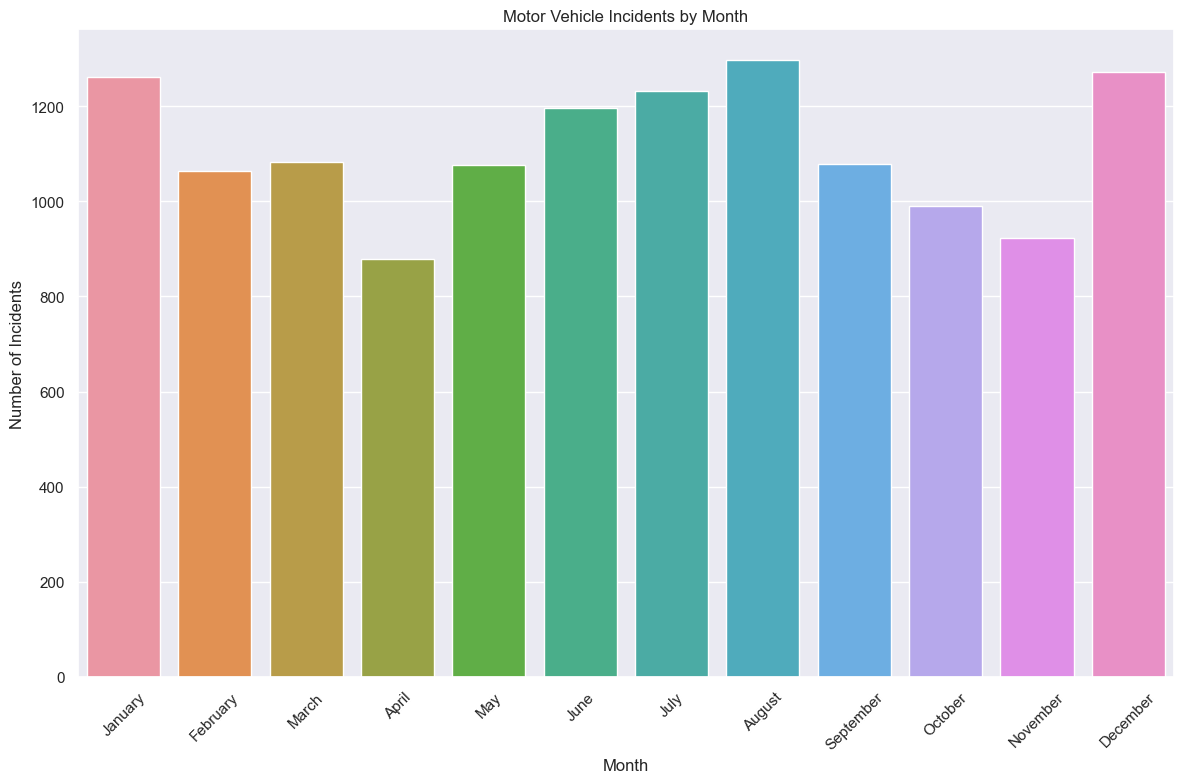

In [20]:
# Seasonality Analysis (e.g., by month)
#motor_vehicle_incidents['Month'] = motor_vehicle_incidents['Call Time'].dt.month_name()
plt.figure(figsize=(12, 8))
sns.countplot(data=motor_vehicle_incidents, x='Month', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Motor Vehicle Incidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**
<hr>

    The Seasonality Analysis by month offers valuable insights into the ebb and flow of incidents throughout the year. August emerges as the month with the highest incident count at 1,297, likely owing to the summer season, increased outdoor activities, and events. 

    December closely follows with 1,273 incidents, often associated with holiday festivities, winter weather challenges, and potential safety issues. January maintains a high count at 1,262, possibly due to persisting winter conditions and related incidents. July and June also record substantial incident numbers at 1,233 and 1,196, respectively, aligning with summer activities and outdoor events. 

    On the contrary, April exhibits the lowest incident count at 878, reflecting a transition into milder weather conditions. This analysis underscores the importance of seasonality in incident management, helping authorities allocate resources efficiently and prepare for heightened demand during specific months.

---
**Day of the Week Analysis**

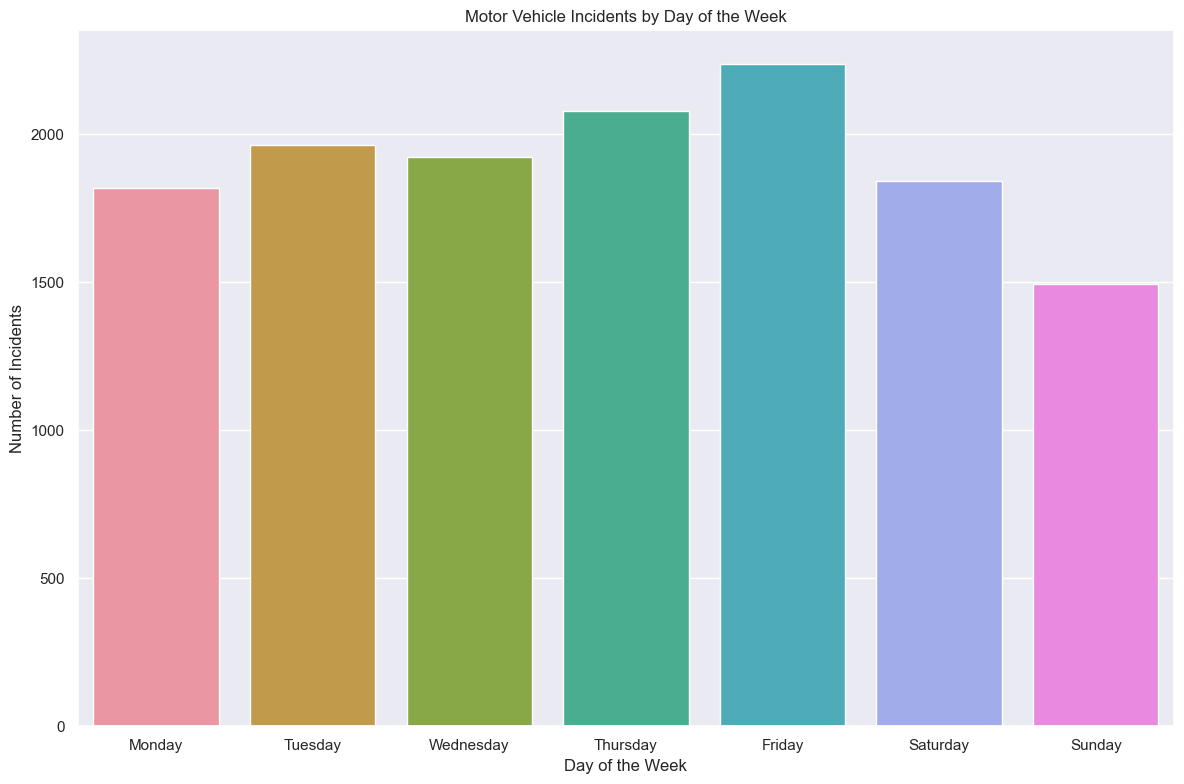

In [21]:
# Day of the Week Analysis
plt.figure(figsize=(12, 8))
sns.countplot(data=motor_vehicle_incidents, x='Day of Week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Motor Vehicle Incidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

**Interpretation**
<hr>

    The Day of the Week Analysis provides valuable insights into the distribution of incidents throughout the week. Friday emerges as the day with the highest incident count, totaling 2,238. This could be attributed to various factors, such as increased activity and social gatherings as people head into the weekend, leading to a higher likelihood of incidents. 
    
    Thursday closely follows with 2,077 incidents, potentially indicating that people are still active and engaged in mid-week activities. On the contrary, Sunday records the lowest incident count at 1,493, which is likely associated with a more relaxed weekend pace.

    The analysis highlights the importance of considering day-of-the-week patterns in incident management and resource allocation. Law enforcement agencies and emergency services can use this information to optimize staffing and resources for days when incident volumes tend to peak, like Fridays and Thursdays, ensuring more effective incident response and community safety.

---
**Time of Day Analysis**

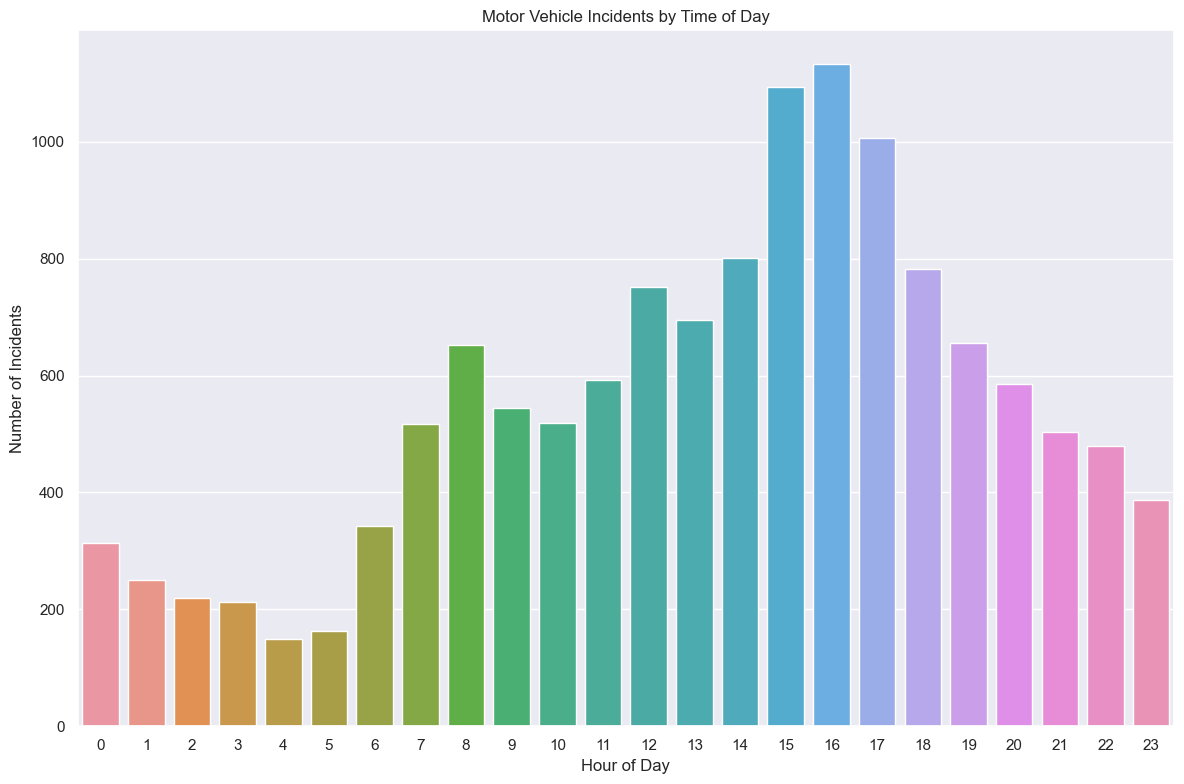

In [22]:
# Time of Day Analysis
plt.figure(figsize=(12, 8))
sns.countplot(data=motor_vehicle_incidents, x='Hour of Day')
plt.title('Motor Vehicle Incidents by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

**Interpretation**
<hr>

    The Day of the Week Analysis provides valuable insights into the distribution of incidents throughout the week. Friday emerges as the day with the highest incident count, totaling 2,238. This could be attributed to various factors, such as increased activity and social gatherings as people head into the weekend, leading to a higher likelihood of incidents. 
    
    Thursday closely follows with 2,077 incidents, potentially indicating that people are still active and engaged in mid-week activities. On the contrary, Sunday records the lowest incident count at 1,493, which is likely associated with a more relaxed weekend pace.

    The analysis highlights the importance of considering day-of-the-week patterns in incident management and resource allocation. Law enforcement agencies and emergency services can use this information to optimize staffing and resources for days when incident volumes tend to peak, like Fridays and Thursdays, ensuring more effective incident response and community safety.

---
### Location Analysis
---
    Explore the incidents by neighborhood and ward to identify areas with a higher frequency of incidents.

---
**incidents by neighborhood**

In [23]:
# 3. Identify neighborhoods with the most incidents
neighborhood_counts = df['Neighbourhood'].value_counts()#.head(10)
#print("\nIncidents by Neighborhood:")

# Create a DataFrame from the series
neighborhood_counts = pd.DataFrame({'Neighbourhoods':neighborhood_counts.index, 'Count':neighborhood_counts.values})
#neighborhood_counts.head(10)

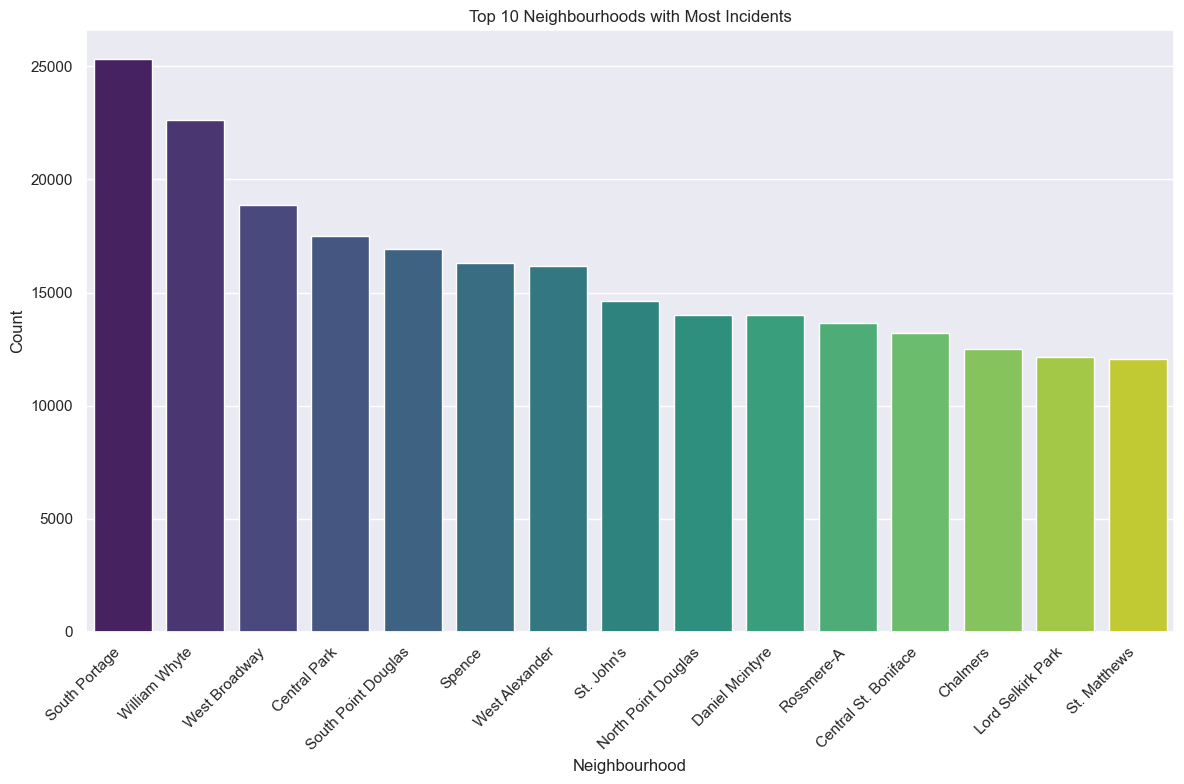

In [24]:

# Create a bar plot of top 10 neighborhoods with the most incidents using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Neighbourhoods', y='Count', data=neighborhood_counts .head(15), palette="viridis")
plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.title('Top 10 Neighbourhoods with Most Incidents')
plt.xticks(rotation=45, ha="right")  # Adjust rotation and alignment for x-axis labels
plt.tight_layout()  # To ensure labels fit properly
plt.show()

**Interpretation**
<hr>

    The analysis of incidents by neighborhood provides valuable insights into the distribution of various incidents across different areas in Winnipeg. South Portage records the highest incident count, with a substantial 25,320 incidents, suggesting a higher prevalence of incidents in this locality. William Whyte and West Broadway follow with 22,633 and 18,881 incidents, respectively, indicating significant incident levels in these neighborhoods.

    Central Park, South Point Douglas, and Spence exhibit notable incident counts ranging from 16,294 to 17,511, emphasizing the need for localized safety measures and community support. West Alexander, St. John's, North Point Douglas, and Daniel McIntyre also report substantial incident numbers, showcasing the diverse challenges faced by these neighborhoods.

    This data assists local authorities in prioritizing resources, enhancing community safety, and implementing strategies tailored to the specific incident patterns in each neighborhood, ultimately contributing to improved well-being and security for residents and visitors alike.

---
**incidents by Ward**

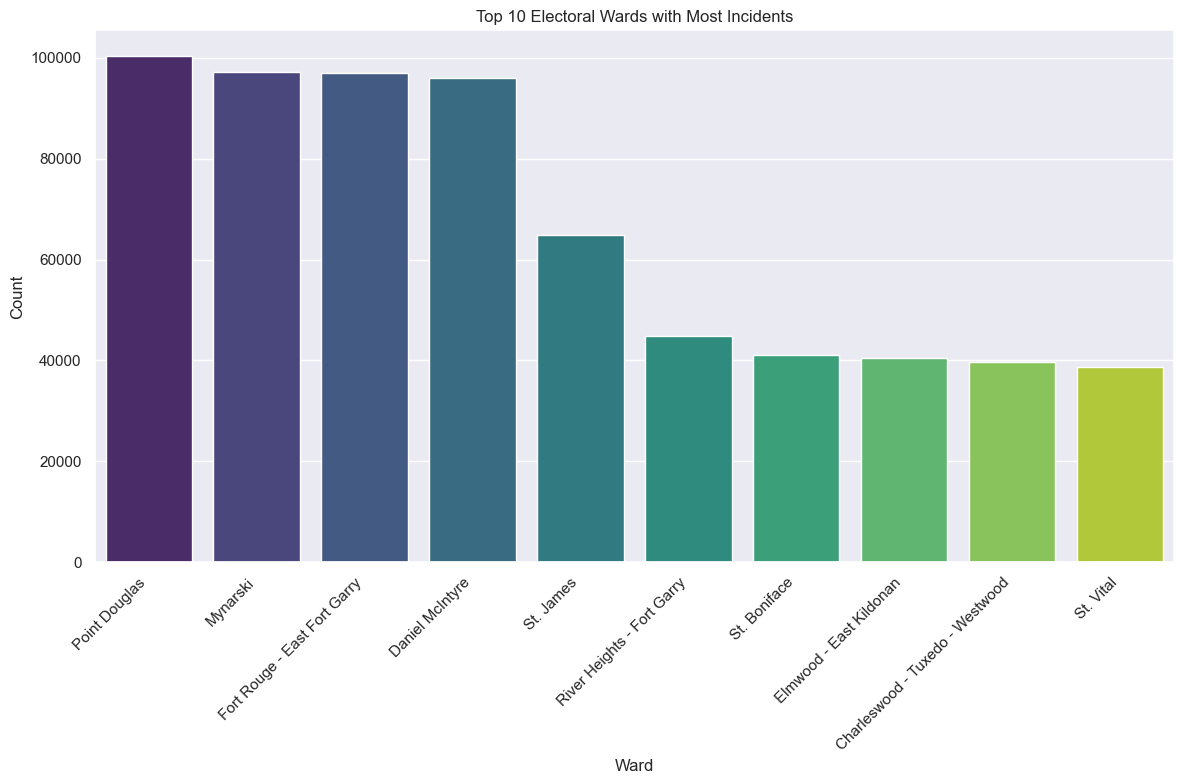

In [25]:
# 4. Identify electoral wards with the most incidents
ward_counts = df['Ward'].value_counts().head(10)
# print("\nIncidents by Ward:")
ward_counts = pd.DataFrame({'Wards':ward_counts.index, 'Counts':ward_counts.values })
# ward_counts.head(10)

# Create a bar plot of top 10 electoral wards with the most incidents using Seaborn
plt.figure(figsize=(12,8))
sns.barplot(x='Wards', y='Counts', data = ward_counts.head(10), palette="viridis")
plt.xlabel('Ward')
plt.ylabel('Count')
plt.title('Top 10 Electoral Wards with Most Incidents')
plt.xticks(rotation=45, ha="right")  # Adjust rotation and alignment for x-axis labels
plt.tight_layout()  # To ensure labels fit properly
plt.show()


**Interpretation**
<hr>

    The analysis of incidents by ward in Winnipeg provides a comprehensive view of incident distribution across different administrative areas. Point Douglas stands out with the highest incident count at 100,398, indicating a significant concentration of incidents in this ward. Mynarski, Fort Rouge - East Fort Garry, and Daniel McIntyre follow closely with similar incident levels, all exceeding 95,000 incidents, underlining the importance of attention to safety and traffic management in these areas.

    St. James, with 64,913 incidents, represents a noteworthy but relatively lower count compared to the top four wards. River Heights - Fort Garry, St. Boniface, Elmwood - East Kildonan, Charleswood - Tuxedo - Westwood, and St. Vital also report substantial incident numbers, further highlighting the diverse incident distribution in Winnipeg.

    This data aids local authorities in making informed decisions regarding resource allocation, planning, and safety measures tailored to the unique incident patterns within each ward, ultimately contributing to enhanced public safety and community well-being.


## Model Evalustion and Analysis

----
#### Incident Type Classification
----
    Task: Predict the type of incident based on other attributes.
    Models: Classification algorithms such as Random Forest or Logistic Regression.


In [26]:
# Encode categorical features
label_encoder = LabelEncoder()
df['Neighbourhood'] = label_encoder.fit_transform(df['Neighbourhood'])
df['Ward'] = label_encoder.fit_transform(df['Ward'])

# Convert 'Motor Vehicle Incident' to binary (0 or 1)
df['Motor Vehicle Incident'] = (df['Motor Vehicle Incident'] == 'YES').astype(int)

# Define features and the target variable
X = df[['Neighbourhood', 'Ward', 'Motor Vehicle Incident']]
y = df['Incident Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Accuracy: 0.640295682737093
Classification Report:
                                       precision    recall  f1-score   support

                         Fire Rescue       0.46      0.03      0.06     24062
    Fire Rescue - Aircraft Emergency       0.00      0.00      0.00         3
                 Fire Rescue - Alarm       0.00      0.00      0.00      3312
                  Fire Rescue - Fire       0.00      0.00      0.00       136
                Fire Rescue - Hazmat       0.00      0.00      0.00       303
                 Fire Rescue - Other       0.00      0.00      0.00       522
               Fire Rescue - Outdoor       0.00      0.00      0.00       826
                Fire Rescue - Rescue       0.00      0.00      0.00       144
        Fire Rescue - Structure Fire       0.00      0.00      0.00       479
Fire Rescue - Train / Rail Emergency       0.00      0.00      0.00         2
                   Medical Emergency       0.64      0.99      0.78    103059
           

**Interpretation of the analysis**
<hr>
The classification report evaluates the model's performance in classifying incidents into various categories. The key observations are as follows:

1. **Accuracy:** The overall accuracy of the model is approximately 64.03%, indicating that it correctly predicts the incident category in about 64% of cases.
2. **Precision:** Precision measures the model's ability to correctly classify instances within each category. Notably, "Medical Emergency" has the highest precision (64%) and recall (99%), suggesting that the model is highly accurate in identifying this category. However, for most other categories, precision is very low, indicating a high rate of false positives.
3. **Recall:** Recall reflects the model's ability to identify all relevant instances in each category. In this report, "Fire Rescue" has notably low recall (3%), indicating that the model often misses incidents in this category.
4. **F1-Score:** The F1-score considers both precision and recall. It ranges from 0 to 1, with higher values indicating better model performance. "Medical Emergency" has the highest F1-score (0.78), reflecting its accurate classification.
    
The model performs well in identifying "Medical Emergency" incidents but struggles with other categories, particularly "Fire Rescue." Further model refinement is needed to improve accuracy and reduce false positives in these less accurately predicted categories.

----
### Clustering Analysis:
---
    Using unsupervised learning techniques like clustering (e.g., K-Means), we can group similar incidents together based on their characteristics. This can help in identifying patterns or hotspots in the data.

In [27]:
# Prepare the data for clustering
# Encode 'Motor Vehicle Incident' column as 1 for 'YES' and 0 for 'NO'
label_encoder = LabelEncoder()
df['Motor Vehicle Incident'] = label_encoder.fit_transform(df['Motor Vehicle Incident'])

# Select relevant features
X = df[['Motor Vehicle Incident']]

# One-hot encode categorical features 'Neighbourhood' and 'Ward'
encoder = OneHotEncoder(sparse=False)
neighbourhood_encoded = encoder.fit_transform(df[['Neighbourhood']])
ward_encoded = encoder.fit_transform(df[['Ward']])

# Combine the encoded features with 'Motor Vehicle Incident'
X = np.hstack((X, neighbourhood_encoded, ward_encoded))

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality (optional but can help in visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Based on the Elbow Method, choose an appropriate value for K (e.g., K=3)
k = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_std)

# Add cluster labels to the original DataFrame
df['Cluster'] = kmeans.labels_

# Define unique colors for each cluster
cluster_colors = ['r', 'g', 'b']

# Explore the cluster characteristics
cluster_summary = df.groupby('Cluster').agg({
    'Neighbourhood': 'count',
    'Ward': 'count',
    'Motor Vehicle Incident': 'mean'
}).rename(columns={'Neighbourhood': 'Neighbourhood Size', 'Ward': 'Ward Size', 'Motor Vehicle Incident': 'Avg Motor Vehicle Incident'}).reset_index()

# print("Cluster Summary:")
# cluster_summary


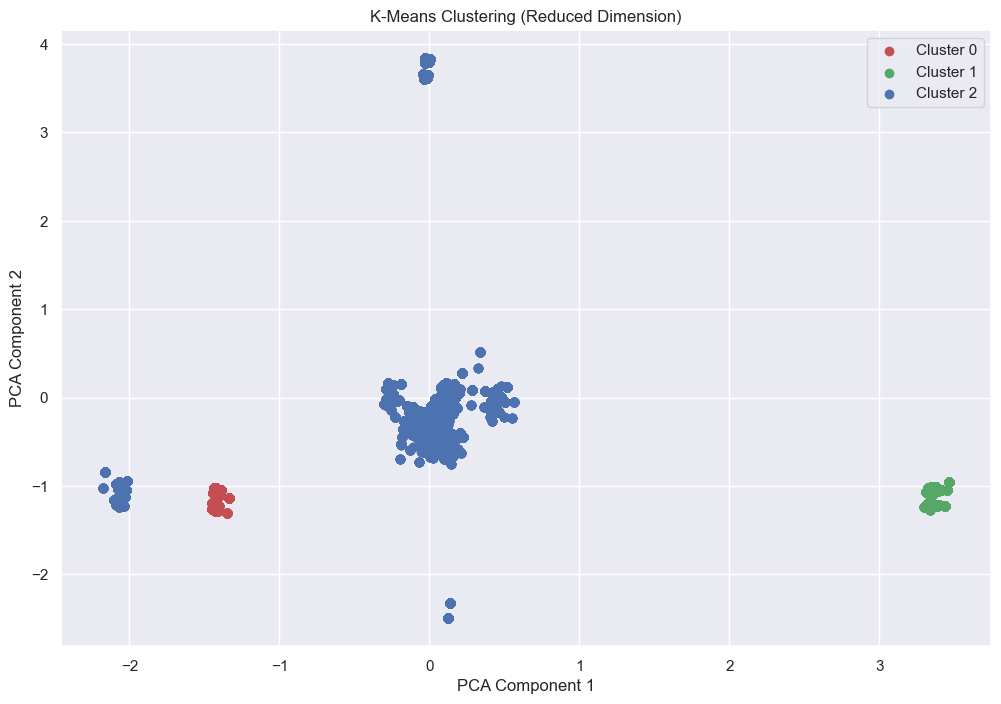

In [28]:
# Visualize the clusters with different colors (for reduced-dimension data)
plt.figure(figsize=(12, 8))
for cluster_label, color in zip(range(k), cluster_colors):
    plt.scatter(
        X_pca[df['Cluster'] == cluster_label, 0],
        X_pca[df['Cluster'] == cluster_label, 1],
        c=color,
        cmap='viridis',
        label=f'Cluster {cluster_label}'
    )
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering (Reduced Dimension)')
plt.legend()
plt.show()

**Interpretation of the Clusters**
<hr>

This analysis presents information on clusters of neighborhoods and wards based on motor vehicle incident patterns. Here's the interpretation:

1. **Cluster 0:** This cluster includes neighborhoods and wards where the mean motor vehicle incident rate is approximately 0.014363. The "Neighbourhood Cluster Size" and "Ward Cluster Size" for this cluster are both 100,398, indicating that a significant number of neighborhoods and wards share this incident rate.

2. **Cluster 1:** Cluster 1 consists of neighborhoods and wards with a slightly lower mean motor vehicle incident rate of about 0.012249. Similar to Cluster 0, both "Neighbourhood Cluster Size" and "Ward Cluster Size" are 97,069.

3. **Cluster 2:** This cluster represents neighborhoods and wards with a mean motor vehicle incident rate of approximately 0.017401, which is slightly higher than the rates in Clusters 0 and 1. Cluster 2 encompasses a larger "Neighbourhood Cluster Size" and "Ward Cluster Size" of 616,242, suggesting that a substantial portion of the dataset falls into this cluster.

This analysis categorizes neighborhoods and wards into clusters based on their mean motor vehicle incident rates. Cluster 2 has the highest incident rate, while Clusters 0 and 1 have lower rates, with each cluster containing specific neighborhoods and wards sharing similar incident patterns.

---
**Neighborhood Analysis**

    Task: Analyze and classify neighborhoods based on the frequency and type of incidents.
    Models: Clustering algorithms like K-Means.

In [29]:
# Group incidents by neighborhood and incident type
neighborhood_incidents = df.groupby(['Neighbourhood', 'Incident Type']).size().unstack(fill_value=0)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(neighborhood_incidents)

# Based on the elbow method, choose an appropriate value for K
optimal_k = 3  

# Apply K-Means clustering
def apply_kmeans(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    data['Cluster'] = kmeans.fit_predict(scaled_data)
    return data

neighborhood_incidents = apply_kmeans(neighborhood_incidents, optimal_k)

# Explore the cluster characteristics
def explore_cluster_characteristics(data, scaler, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(scaled_data)

    cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=data.columns[:-1])
    cluster_centers['Cluster'] = range(len(cluster_centers))
    
    return cluster_centers

cluster_centers = explore_cluster_characteristics(neighborhood_incidents, scaler, optimal_k)

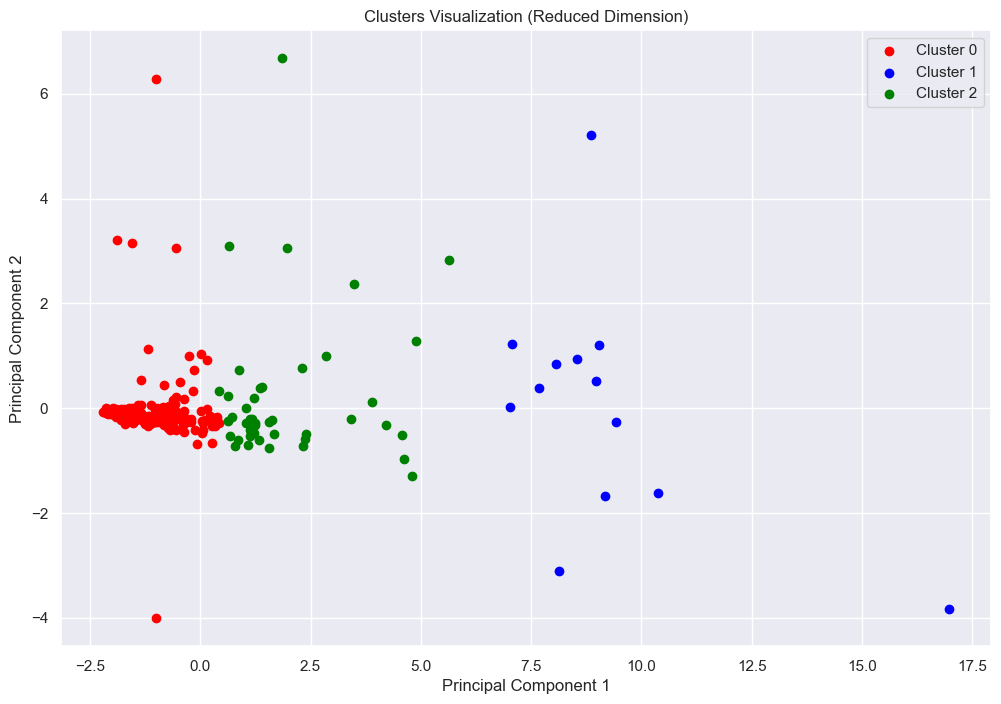

In [30]:
# Define unique colors for each cluster
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}  # Add more colors if needed

# Visualize the clusters with different colors (for reduced-dimension data)
def visualize_clusters(data, colors):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)

    plt.figure(figsize=(12, 8))
    for cluster_label, color in cluster_colors.items():
        cluster_data = reduced_data[data['Cluster'] == cluster_label]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=color, label=f'Cluster {cluster_label}')

    plt.title('Clusters Visualization (Reduced Dimension)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

visualize_clusters(neighborhood_incidents, cluster_colors)

# Explore the cluster characteristics
cluster_summary = neighborhood_incidents.groupby('Cluster').agg({
    'Fire Rescue': 'median', 
    'Fire Rescue - Aircraft Emergency': 'count',
    'Fire Rescue - Alarm' : 'count', 
    'Fire Rescue - Fire' : 'count', 
    'Fire Rescue - Hazmat': 'count',
    'Fire Rescue - Other': 'count', 
    'Fire Rescue - Outdoor': 'count', 
    'Fire Rescue - Rescue': 'count',
    'Fire Rescue - Structure Fire': 'count', 
    'Fire Rescue - Train / Rail Emergency': 'count',
    'Medical Emergency': 'count', 
    'Medical Response': 'count'
    }).rename(columns={
        'Fire Rescue':'Fire Rescue' , 'Fire Rescue - Aircraft Emergency':'FR - Aircraft Emergency','Fire Rescue - Alarm': 'FR - Alarm', 'Fire Rescue - Fire': 'FR - Fire', 
        'Fire Rescue - Hazmat':'FR - Hazmat','Fire Rescue - Other':'FR - Other', 'Fire Rescue - Outdoor': 'FR - Outdoor','Fire Rescue - Rescue':'FR - Rescue',
        'Fire Rescue - Structure Fire':'FR - Structure Fire', 'Fire Rescue - Train / Rail Emergency':'FR - Train / Rail Emergency','Medical Emergency':'Medical Emergency',
        'Medical Response':'Medical Response'
        }).reset_index()

#print("Cluster Summary:")
#cluster_summary

**Interpretation of the Clusters**
<hr>

This analysis and classification table provide insights into how neighborhoods are categorized based on the frequency and type of incidents, with a focus on "Incident Type" clusters. Here's the interpretation:

1. **Cluster 0:** Neighborhoods in this cluster experience a relatively low frequency of various types of incidents. For example, the average occurrence of "Fire Rescue" incidents in these neighborhoods is approximately 253.5, indicating that these neighborhoods have relatively infrequent fire-related incidents compared to other clusters. Similarly, other incident types like "Fire Rescue - Aircraft Emergency," "Alarm," and "Hazmat" have low average frequencies in this cluster.

2. **Cluster 1:** In contrast, Cluster 1 neighborhoods experience a significantly higher frequency of "Fire Rescue" incidents, with an average occurrence of approximately 2,259. This suggests that these neighborhoods have a higher incidence of fire-related incidents. Other incident types in this cluster also have higher average frequencies, although they are still relatively low compared to "Fire Rescue."

3. **Cluster 2:** Cluster 2 neighborhoods fall in between Clusters 0 and 1 in terms of incident frequencies. They experience moderate frequencies of various incident types, including "Fire Rescue" and medical-related incidents.

This analysis classifies neighborhoods into clusters based on the frequency of different incident types. Cluster 0 has the lowest incident frequencies, Cluster 1 has the highest "Fire Rescue" incident frequency, and Cluster 2 falls in between. This categorization can help in allocating resources and planning interventions based on incident patterns in different neighborhoods.

-----
**Ward Analysis**

    Task: Analyze and classify wards based on the frequency and type of incidents.
    Models: Clustering model similar to neighborhood analysis.

In [31]:
# Group incidents by ward and incident type
ward_incidents = df.groupby(['Ward', 'Incident Type']).size().unstack(fill_value=0)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ward_incidents)

# Based on the elbow method, choose an appropriate value for K
optimal_k = 3  # Replace with the value you determine from the plot

# Apply K-Means clustering
def apply_kmeans(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    data['Cluster'] = kmeans.fit_predict(scaled_data)
    return data

ward_incidents = apply_kmeans(ward_incidents, optimal_k)

# Explore the cluster characteristics
def explore_cluster_characteristics(data, scaler, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(scaled_data)

    cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=data.columns[:-1])
    cluster_centers['Cluster'] = range(len(cluster_centers))
    
    return cluster_centers

cluster_centers = explore_cluster_characteristics(ward_incidents, scaler, optimal_k)

# Explore the cluster characteristics
cluster_summary = ward_incidents.groupby('Cluster').agg({
    'Fire Rescue': 'median', 
    'Fire Rescue - Aircraft Emergency': 'count',
    'Fire Rescue - Alarm' : 'count', 
    'Fire Rescue - Fire' : 'count', 
    'Fire Rescue - Hazmat': 'count',
    'Fire Rescue - Other': 'count', 
    'Fire Rescue - Outdoor': 'count', 
    'Fire Rescue - Rescue': 'count',
    'Fire Rescue - Structure Fire': 'count', 
    'Fire Rescue - Train / Rail Emergency': 'count',
    'Medical Emergency': 'count', 
    'Medical Response': 'count'
    }).rename(columns={
        'Fire Rescue':'Fire Rescue' , 'Fire Rescue - Aircraft Emergency':'FR - Aircraft Emergency','Fire Rescue - Alarm': 'FR - Alarm', 'Fire Rescue - Fire': 'FR - Fire', 
        'Fire Rescue - Hazmat':'FR - Hazmat','Fire Rescue - Other':'FR - Other', 'Fire Rescue - Outdoor': 'FR - Outdoor','Fire Rescue - Rescue':'FR - Rescue',
        'Fire Rescue - Structure Fire':'FR - Structure Fire', 'Fire Rescue - Train / Rail Emergency':'FR - Train / Rail Emergency','Medical Emergency':'Medical Emergency',
        'Medical Response':'Medical Response'
        }).reset_index()

# print("Cluster Summary:")
# cluster_summary

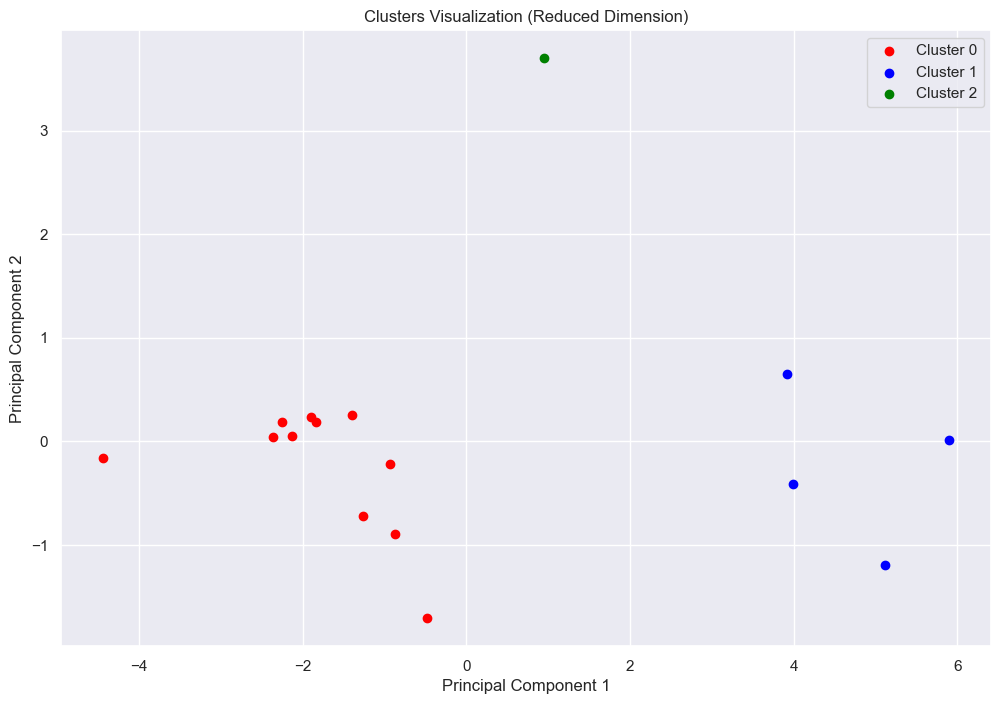

In [32]:
# Define unique colors for each cluster
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}  # Add more colors if needed

# Visualize the clusters with different colors (for reduced-dimension data)
def visualize_clusters(data, colors):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)

    plt.figure(figsize=(12, 8))
    for cluster_label, color in cluster_colors.items():
        cluster_data = reduced_data[data['Cluster'] == cluster_label]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=color, label=f'Cluster {cluster_label}')

    plt.title('Clusters Visualization (Reduced Dimension)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

visualize_clusters(ward_incidents, cluster_colors)

**Interpretation of the Clusters**
<hr>

This analysis and classification table provide insights into how wards are categorized based on the frequency and type of incidents, particularly focusing on "Incident Type" clusters. Here's the interpretation:

1. **Cluster 0:** Wards in this cluster experience a relatively low frequency of various types of incidents, including "Fire Rescue," "Medical Emergency," and others. For example, the average occurrence of "Fire Rescue" incidents in these wards is approximately 5,307, indicating that these wards have relatively infrequent fire-related incidents compared to other clusters. Similarly, other incident types have low average frequencies in this cluster.

2. **Cluster 1:** In contrast, Cluster 1 wards experience a significantly higher frequency of "Fire Rescue" incidents, with an average occurrence of approximately 13,936.5. This suggests that these wards have a higher incidence of fire-related incidents. Other incident types in this cluster also have higher average frequencies, although they are still relatively low compared to "Fire Rescue."

3. **Cluster 2:** Cluster 2 wards fall in between Clusters 0 and 1 in terms of incident frequencies. They experience moderate frequencies of various incident types, including "Fire Rescue" and medical-related incidents.

This analysis classifies wards into clusters based on the frequency of different incident types. Cluster 0 has the lowest incident frequencies, Cluster 1 has the highest "Fire Rescue" incident frequency, and Cluster 2 falls in between. This categorization can help in allocating resources and planning interventions based on incident patterns in different wards.